In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

In [85]:
Ls = [20, 50, 100]
bs = [1.651, 1.675, 1.701, 1.725, 1.751, 1.801, 1.825, 1.851]
Nfields = 25
DROP = 10**3
CALC = 2*10**4

p_c = .5 # probability of being assigned strategy C

In [4]:
for L in Ls:
    for idx in range(Nfields):
        np.save("field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

In [ ]:
0 - 0 -> 0
0 - 1 -> b
1 - 0 -> 0
1 - 1 -> 1

In [3]:
%load_ext cython

In [29]:
%%cython -a
import numpy as np
cimport cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve(long[:, :] field, double b, long num_epoch=1):
    cdef:
        int L = field.shape[0]
        int x, y, x1, x2, x3, y1, y2, y3, i, j, bestX, bestY
        long[:, :] next_state = np.zeros((L, L), dtype=int)
        double[:, :] scores = np.zeros((L, L), dtype=float)
        double[:, :] _zeros = np.zeros((L, L), dtype=float)
        
    assert L != 0
    
    next_state = field.copy()
    
    for _ in range(num_epoch):
        scores[...] = _zeros
        for x in range(L):
            for y in range(L):
                x1, x2, x3 = (x-1)%L, x%L, (x+1)%L
                y1, y2, y3 = (y-1)%L, y%L, (y+1)%L
                scores[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] + field[x2, y1] + field[x2, y2] + field[x2, y3] + field[x3, y1] + field[x3, y2] + field[x3, y3])
                if field[x, y] == 0:
                    scores[x, y] *= b
#         return scores
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if scores[(x+i)%L, (y+j)%L] > scores[bestX, bestY]:
                            bestX = (x+i)%L
                            bestY = (y+j)%L

                next_state[x, y] = field[bestX, bestY]
        
        field = next_state.copy()
        
    return np.asarray(field)

In [5]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
cimport cython # на уровне C
from cython.parallel cimport prange

@cython.cdivision(True) # Отключаем проверку L != 0 при взятии остатка
@cython.boundscheck(False) # Отключаем проверку на выход за границы
def evolve2_1(long int[:, :] field, double b, int num_steps=1):
    
    cdef:
        int L = field.shape[0]
        int x, y, i, j, step, ix, jy, bestX, bestY
        double[:, :] scores = np.zeros((L, L), dtype=float) # type memmory view
        double[:, :] _zeros = np.zeros((L, L), dtype=float)
        
#     L = field.shape[0]
        long[:, :] current = np.zeros((L, L), dtype=int)
#     scores = np.zeros((L, L), dtype=float)
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        
        with nogil: # Отпустить global lock(только если все белое)
            for x in prange(L):
                for y in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            scores[x, y] += (1 - field[ix, jy])

                    if field[x, y] == 1:
                        scores[x, y] *= b

            for x in prange(L):
                for y in range(L):
                    bestX = x
                    bestY = y
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            if (scores[bestX, bestY] < scores[ix, jy]):
                                bestX = ix
                                bestY = jy

                    field[x, y] = current[bestX, bestY]
    return np.asarray(field)

In [5]:
density = []
for b in tqdm(bs):
    d = []
    for i in range(Nfields):
        field = np.load("field_50_{}.npy".format(i))
        field = evolve(field, b, DROP)
        for _ in range(CALC-DROP):
            field = evolve(field, b)
#             print(field.sum()/(1.*50^2))
            d.append(field.sum()/(1.*field.shape[0]**2))
    density.append(d)

100%|██████████| 8/8 [28:24<00:00, 214.57s/it]


In [12]:
means = np.asarray(density).mean(axis=1)

In [13]:
bs

[1.651, 1.675, 1.701, 1.725, 1.751, 1.801, 1.825, 1.851]

In [14]:
means

array([0.2034904 , 0.075684  , 0.075684  , 0.075684  , 0.076808  ,
       0.05282346, 0.05282346, 0.05282346])

In [90]:
b = 1.71
L = 75
np.random.seed(43)
field1 = np.random.choice((0, 1), (L, L), p=(1-p_c, p_c))

<IPython.core.display.Javascript object>


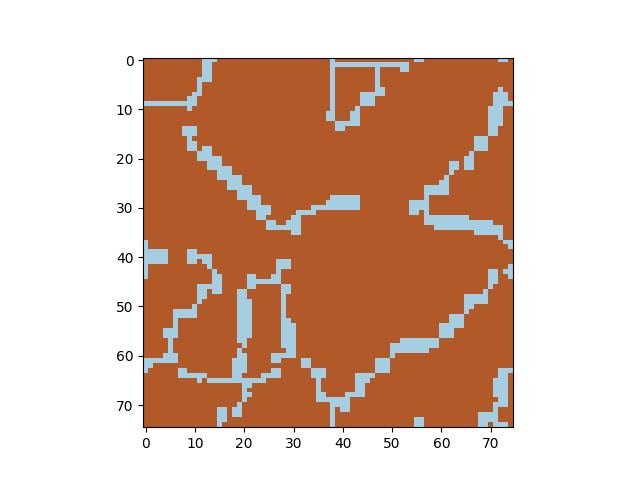

In [89]:
fig = plt.figure()
im = plt.imshow(field1, animated=True, cmap=plt.get_cmap('Paired'))

# updater function
def updatefig(*args):
    global field1
    field1 = evolve(field1.copy(), b, 1)
    im.set_array(field1)
    return im,

# animate!
anim = animation.FuncAnimation(fig, updatefig, frames=200, interval=50, blit=True)

plt.show()

In [70]:
for _

0.7089777777777778